LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(37)

Mounted at /content/drive


# 0.Data Load

In [52]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [53]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Pre-processing

## 1.1 EDA
1. `Y_Quality` and `X features`: 
    - NOT high correlation, yet  

In [5]:
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

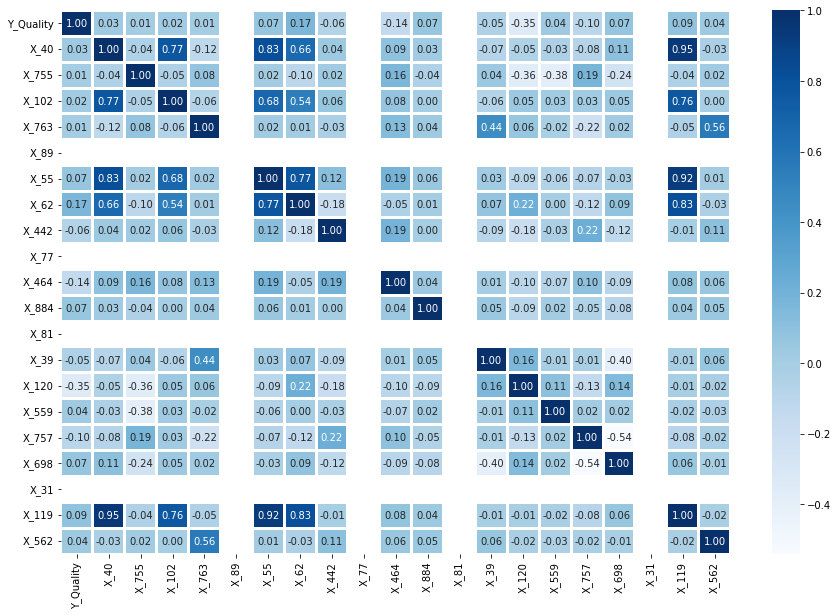

In [6]:
# heatmap: `random X features` and `Y_Quality` correlation 
import random
a = ['Y_Quality']

for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

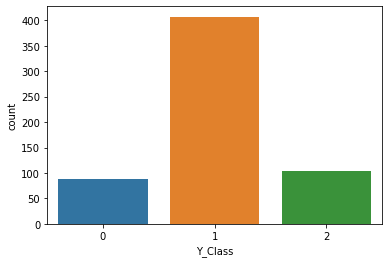

In [7]:
# UNBALANCED data --> metrics: precision, recall, f1-score 
sns.countplot(x='Y_Class', data=train_df);

## 1.2 Merge & Encoding
1. Merge `LINE` & `PRODUCT_CODE` & `Y_Class`columns by JOIN function
    - set the joined column name as `line_pcode_class`
2. Label encoding 
    - encode qualitative into quantitative

In [54]:
train_df['Y_Class'] = train_df['Y_Class'].astype(str)

col = ['LINE', 'PRODUCT_CODE', 'Y_Class']
train_df['line_pcode_class'] = train_df[col].apply(lambda row: ':'.join(row.values), axis=1)
train_df = train_df.drop(columns=['LINE', 'PRODUCT_CODE'])  

print(train_df['line_pcode_class'].value_counts())  

T100306:T_31:1    144
T100304:T_31:1    141
T050304:A_31:1     37
T010306:A_31:1     37
T010305:A_31:1     35
T050304:A_31:0     30
T010306:A_31:2     27
T050307:A_31:2     22
T100304:T_31:0     17
T100306:T_31:2     16
T100304:T_31:2     14
T010305:A_31:0     13
T050304:A_31:2     11
T010305:A_31:2     11
T050307:A_31:0     11
T100306:T_31:0     11
T050307:A_31:1      9
T010306:A_31:0      6
T100304:O_31:1      3
T100306:O_31:2      2
T100306:O_31:1      1
Name: line_pcode_class, dtype: int64


In [55]:
# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode_class']

for i in col:
    train_df[i] = encoder.fit_transform(train_df[i])

# correlation
# print(train_x[['Y_Quality', 'line_pcode']].corr()) 

In [56]:
train_df.line_pcode_class.unique()

array([ 7, 11,  8, 13, 14, 19,  5,  0,  1,  6, 10,  4,  2, 15,  3, 18, 20,
        9, 12, 17, 16])

In [57]:
# line_pcode & Y_Class  
# sns.countplot(train_df, col='Y_Class', hue='line_pcode');

# f = sns.FacetGrid(train_x, col="Y_Class")  
# f.map_dataframe(sns.histplot, x="line_pcode", binwidth=0.9);    

## 1.3 Missing Values

In [58]:
# 1) features that have only 'NaN' 
## Total 81 features only have 'NaN' 
miss_dic = train_df.isnull().sum().to_dict()
all_NaN = pd.DataFrame({i for i in miss_dic if miss_dic[i]==598})
all_NaN_name = list(all_NaN[0])  # all_NaN features name in list 
print(len(all_NaN_name))  

82


In [59]:
all_NaN2 = pd.DataFrame(np.zeros((82,82)), columns=list(all_NaN[0]))

for i in all_NaN_name: 
    train_df[i] = train_df[i].apply(lambda x: 0)
train_df.X_2686.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [60]:
# 2) fillout remaining NULL with 'line_pcdoe' median

median_dic = {}
for i in range(21): 
    a = train_df.loc[train_df['line_pcode_class']==i] 
    m = a.median().median()     
    median_dic[i] = m
    a.fillna(m, inplace=True)
    train_df.loc[train_df['line_pcode_class']==i] = a  

print(median_dic)     

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-pack

{0: 20.8, 1: 19.8, 2: 19.2, 3: 20.9791666675, 4: 19.5, 5: 19.0, 6: 48.8, 7: 48.9, 8: 48.9, 9: 51.6, 10: 52.0, 11: 51.2, 12: 9.0, 13: 9.05, 14: 9.0, 15: 9.0, 16: 8.6966666665, 17: 8.75, 18: 9.0, 19: 9.0, 20: 9.0}


## 1.4 Scaling

[outlier Dection: IsolationForest](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

### 1.4.1 Outliers

In [61]:
xs = list(train_df.iloc[:, 6:].columns)

In [62]:
# outlier (replace 1Q, 3Q with MEDIAN)
def outlier(df):
    for col in xs: 
        q1 = train_df[col].quantile(0.25)
        q3 = train_df[col].quantile(0.75)
        median = train_df[col].quantile(0.50)

        train_df[col] = np.where(train_df[col]<q1, median, train_df[col])
        train_df[col] = np.where(train_df[col]>q3, median, train_df[col])

train_df 

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode_class
0,1,0.533433,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,...,40.890000,32.560000,34.090000,77.770000,48.900000,0,0,0,0,7
1,2,0.541819,51.2,51.2,51.2,51.2,51.2,51.2,51.2,51.2,...,42.820000,43.920000,35.340000,72.550000,51.200000,0,0,0,0,11
2,1,0.531267,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,...,36.650000,42.470000,36.530000,78.350000,48.900000,0,0,0,0,7
3,2,0.537325,51.2,51.2,51.2,51.2,51.2,51.2,51.2,51.2,...,39.170000,52.170000,30.580000,71.780000,51.200000,0,0,0,0,11
4,1,0.531590,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,...,41.890000,46.930000,33.090000,76.970000,48.900000,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,0.526546,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,9.000000,9.000000,9.000000,9.000000,9.000000,0,0,0,0,19
594,0,0.524022,48.8,48.8,48.8,48.8,48.8,48.8,48.8,48.8,...,53.070000,50.890000,55.100000,66.490000,1.000000,0,0,0,0,6
595,0,0.521289,48.8,48.8,48.8,48.8,48.8,48.8,48.8,48.8,...,48.800000,48.800000,48.800000,48.800000,1.000000,0,0,0,0,6
596,1,0.531375,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,9.000000,9.000000,9.000000,9.000000,9.000000,0,0,0,0,12


In [63]:
train_df.describe()

,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode_class
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.0,598.0,598.000000
mean,0.530896,15.634072,69.742768,14.227717,40.490259,20.292935,14.227717,42.709323,20.092266,38.430059,...,20.128581,19.459434,19.802846,22.309518,11.412912,0.0,0.0,0.0,0.0,11.807692
std,0.007401,18.991764,31.766601,19.470502,11.110994,15.252952,19.470502,12.576686,15.380152,13.127259,...,17.355424,16.002440,16.795288,21.532037,9.409032,0.0,0.0,0.0,0.0,6.200028
min,0.500856,1.000000,19.000000,0.000000,19.000000,10.000000,0.000000,19.000000,10.000000,19.000000,...,8.696667,8.696667,8.696667,8.696667,1.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.527535,2.000000,48.800000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,0.0,0.0,0.0,0.0,6.000000
50%,0.530436,2.000000,91.000000,0.000000,45.000000,11.000000,0.000000,45.000000,10.000000,31.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,0.0,0.0,0.0,0.0,14.000000
75%,0.533433,19.800000,95.000000,19.800000,45.000000,19.800000,19.800000,51.000000,19.800000,52.000000,...,19.800000,19.800000,19.800000,19.800000,16.512500,0.0,0.0,0.0,0.0,19.000000
max,0.578841,103.000000,102.000000,52.000000,52.000000,52.000000,52.000000,62.000000,52.000000,52.000000,...,68.660000,60.410000,59.930000,79.750000,51.200000,0.0,0.0,0.0,0.0,20.000000


## 1.5 Test_df Preprocessing

In [64]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
test_df['line_pcode'] = test_df[col].apply(lambda row: ':'.join(row.values), axis=1)
test_df = test_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
col = ['line_pcode']

for i in col:
    test_df[i] = encoder.fit_transform(test_df[i])

In [65]:
# Missing Values
# 1) features that have only 'NaN' without any recorded values 
## Total 506 features only have 'NaN' 
miss_dic = test_df.isnull().sum().to_dict()
all_nan = pd.DataFrame({i for i in miss_dic if miss_dic[i]==310})
all_nan_name = list(all_nan[0])  # all_NaN features name in list 

for i in all_nan_name: 
    test_df[i].fillna(0, inplace=True)
test_df.X_2277.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [66]:
len(test_df['line_pcode'].unique())

8

In [67]:
# 2) fillout remaining NULL with 'line_pcdoe' median

median_dic = {}
for i in range(8): 
    a = test_df.loc[test_df['line_pcode']==i] 
    m = a.median().median()    
    median_dic[i] = m  
    a.fillna(m, inplace=True)
    test_df.loc[test_df['line_pcode']==i] = a

print(median_dic)  

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/usr/local/lib/python3.8/dist-pack

{0: 0.9, 1: 0.8500000000000001, 2: 7.3306451615, 3: 3.9975, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}


In [68]:
# outlier (replace 1Q, 3Q with MEDIAN)
xs = list(test_df.iloc[:, 6:].columns)
def outlier(df):
    for col in xs: 
        q1 = test_df[col].quantile(0.25)
        q3 = test_df[col].quantile(0.75)
        median = test_df[col].quantile(0.50)

        test_df[col] = np.where(test_df[col]>q3, median, test_df[col])

test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.121721,74.757204,0.721721,35.995914,8.773334,0.721721,38.728172,8.570108,33.963656,2.289463,...,5.979528,5.648270,6.109786,7.163109,0.201613,7.805342,7.918567,7.669213,7.249535,5.138710
std,14.760337,37.749826,1.775472,17.211959,3.095255,1.775472,18.936568,2.972388,18.620747,1.249758,...,16.614796,15.734697,16.959788,19.936360,0.389399,41.834183,42.411567,41.243141,38.544468,2.064522
min,0.850000,0.850000,0.000000,0.850000,0.850000,0.000000,0.850000,0.850000,0.850000,0.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,87.250000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,93.000000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2.000000,96.000000,0.000000,45.000000,10.000000,0.000000,50.000000,10.000000,52.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,154.000000,102.000000,7.330645,45.000000,11.000000,7.330645,67.000000,11.000000,52.000000,7.330645,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


# 2.Modeling_ML

In [69]:
X_train = train_df.drop(columns=['Y_Class','Y_Quality'])
y_train = train_df['Y_Quality']

test_x = test_df   

In [70]:
test_x.isnull().sum()

X_1           0
X_2           0
X_3           0
X_4           0
X_5           0
             ..
X_2872        0
X_2873        0
X_2874        0
X_2875        0
line_pcode    0
Length: 2876, dtype: int64

## Y_Quality 예측

In [71]:
from sklearn.ensemble import GradientBoostingRegressor   

RF = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [72]:
preds=RF.predict(test_x)  
print('Done.')

Done.


In [73]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.00,94.00,0.00,45.00,10.00,0.00,51.00,10.00,52.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,0.540655
1,2.00,93.00,0.00,45.00,11.00,0.00,45.00,10.00,31.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,0.537758
2,2.00,95.00,0.00,45.00,11.00,0.00,45.00,10.00,31.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,0.538051
3,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,...,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0,0.521730
4,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,...,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,1,0.522480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.00,91.00,0.00,45.00,10.00,0.00,51.00,10.00,52.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,0.540027
306,2.00,96.00,0.00,45.00,11.00,0.00,45.00,10.00,31.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,0.540168
307,2.00,91.00,0.00,45.00,10.00,0.00,50.00,10.00,52.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,0.539932
308,2.00,95.00,0.00,45.00,10.00,0.00,51.00,10.00,52.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,0.539866


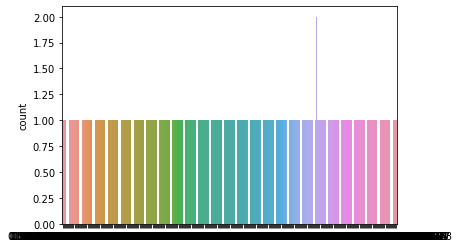

In [74]:
sns.countplot(x=preds);

## 다시 Y_Class 예측

In [116]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
y_train = train_df['Y_Class']

In [117]:
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [118]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [119]:
X_train

,Y_Quality
0,0.533433
1,0.541819
2,0.531267
3,0.537325
4,0.531590
...,...
593,0.526546
594,0.524022
595,0.521289
596,0.531375


In [120]:
from sklearn.ensemble import GradientBoostingClassifier

RF =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [124]:
# test_x
# test_x = test_x['Y_Quality']
# test_x = test_x.drop(columns=['LINE','PRODUCT_CODE'])
test_x = test_x['Y_Quality']  

In [125]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)  
print('Done.')   

Done.


In [126]:
preds

array(['2', '2', '2', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0',
       '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '0', '2',
       '0', '0', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '1', '1', '1', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1',
       '0', '1', '2', '2', '2', '2', '0', '0', '2', '2', '2', '2', '2',
       '2', '0', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '0', '2', '2', '2', '2', '0', '0', '0',
       '0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0',
       '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

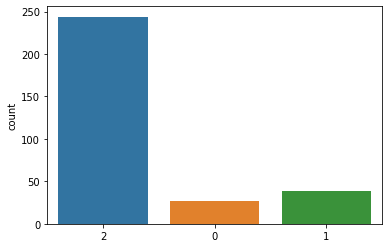

In [127]:
sns.countplot(x=preds);

## 2.1 Random Forest

In [31]:
# RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
# print('Done')

In [36]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=37)

In [38]:
RF_model = RandomForestClassifier()   

In [39]:
X_train 

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
240,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.00,19.00,19.00,19.00,19.0,0,0,0,0,1
185,2.0,97.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,9.00,9.00,9.00,9.00,9.0,0,0,0,0,5
315,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,48.9,...,61.84,40.60,56.59,65.12,1.0,0,0,0,0,2
410,20.2,20.2,20.2,20.2,20.2,20.2,20.2,20.2,20.2,20.2,...,20.20,20.20,20.20,20.20,20.2,0,0,0,0,0
396,2.0,96.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,9.00,9.00,9.00,9.00,9.0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,1.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,9.00,9.00,9.00,9.00,9.0,0,0,0,0,7
22,2.0,102.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,9.00,9.00,9.00,9.00,9.0,0,0,0,0,5
437,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,19.00,19.00,19.00,19.00,19.0,0,0,0,0,1
251,2.0,101.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,9.00,9.00,9.00,9.00,9.0,0,0,0,0,5


In [40]:
fitted = RF_model.fit(X_train, y_train) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_model = RandomForestClassifier(n_estimators = 10,
                                            oob_score=False)
RandomForest_model.fit(X_train, y_train)
RF_predict = tf.cast(RandomForest_model.predict(X_test) > 0.5, 
                     dtype = tf.float32)

print('Accuracy = ', accuracy_score(RF_predict, y_test))
print("Test Report = \n", classification_report(RF_predict, y_test))

In [41]:
print(fitted.score(X_train, y_train))
print(fitted.score(X_test, y_test))

1.0
0.7533333333333333


In [42]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=37, shuffle=False)

# clf = RandomForestClassifier(max_depth=2, random_state=37)
# clf.fit(X,y)
# print(clf.predict([[0,0,0,0]]))

# 3.Modeling_DL

# 4.Model Comparison

# 5.Inference
- finally, performs perdiction for test set

In [43]:
test_x.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.121721,74.757204,0.721721,35.995914,8.773334,0.721721,38.728172,8.570108,33.963656,2.289463,...,5.979528,5.648270,6.109786,7.163109,0.201613,7.805342,7.918567,7.669213,7.249535,5.138710
std,14.760337,37.749826,1.775472,17.211959,3.095255,1.775472,18.936568,2.972388,18.620747,1.249758,...,16.614796,15.734697,16.959788,19.936360,0.389399,41.834183,42.411567,41.243141,38.544468,2.064522
min,0.850000,0.850000,0.000000,0.850000,0.850000,0.000000,0.850000,0.850000,0.850000,0.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,87.250000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,93.000000,0.000000,45.000000,10.000000,0.000000,45.000000,10.000000,31.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2.000000,96.000000,0.000000,45.000000,10.000000,0.000000,50.000000,10.000000,52.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,154.000000,102.000000,7.330645,45.000000,11.000000,7.330645,67.000000,11.000000,52.000000,7.330645,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


In [44]:
preds = RF_model.predict(test_x)
print('Done.')

Done.


In [45]:
test_x['Y_Class']=preds
preds

array([2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

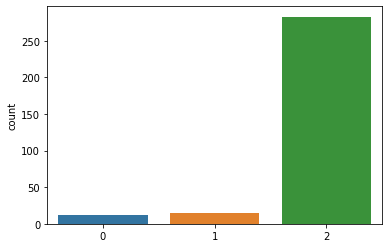

In [48]:
sns.countplot(x=preds);

# 6.Submit

In [129]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

# THE END
